In [203]:
from bindsnet.network import Network
from bindsnet.network.nodes import LIFNodes
from bindsnet.network.nodes import Input
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.network.monitors import NetworkMonitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages
import torch
import matplotlib.pyplot as plt
from torch import bernoulli, ones, randn
from time import time
from tqdm import tqdm

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from torchvision import transforms
import os

from bindsnet.analysis.plotting import (
    plot_input,
    plot_spikes,
    plot_voltages,
    plot_weights,
)
#!echo "./data/MNIST" >> ./.gitignore ### run once only

In [131]:
total_timesteps = 500
dt = 1
num_epochs = 1
progress_interval = 10
update_interval = 250

intensity = 128

image_shape = (32, 32)
dendrite_field_shape = image_shape
num_dendrite_layers = 2
dendrite_span = 5 #in pixels

seed = 8
batch_size = 1


torch.manual_seed(seed)
network = Network(dt=dt, learning=True, batch_size=1, reward_fn=None)

### In this setup, the physical weights between neurons don't change in the short term, only the dendritic feedback stimulation. Hence we first connect the network randomly.

# Version 1: Feedback dendrites have unlimited span but make relatively sparse connections

In [126]:
connection_prob = 0.3 #probability of any given feedback neuron
                      #connecting to any given sensory neuron

input_layer = Input(n=32*32, shape=image_shape, traces=True)
sensory_layer = LIFNodes(n=32*32, shape=image_shape, traces=True)

input_sensory_connection = Connection(
                source=input_layer,
                target=sensory_layer,
                w = torch.ones((input_layer.n, sensory_layer.n)))

network.add_layer(input_layer, 'simulated input')
network.add_layer(sensory_layer, 'light-receptive neurons')
network.add_connection(input_sensory_connection,
                       source='simulated input',
                       target='light-receptive neurons')


dendrite_layers_container = []
dendrite_connections_container = []

dfs = dendrite_field_shape

for iii in range(num_dendrite_layers):
    dendrite_layers_container.append(LIFNodes(n=32*32, shape=dfs,
                                    traces=True))
    network.add_layer(dendrite_layers_container[iii], f"feedback {iii}")
    
    
    weights = bernoulli(connection_prob*ones(dfs))*randn(dfs)
    
    dendrite_connections_container.append(Connection(
                            source=dendrite_layers_container[iii],
                            target=sensory_layer,
                            w = weights ))
    network.add_connection(dendrite_connections_container[iii],
                           source=f"feedback {iii}",
                           target='light-receptive neurons')
    
print("Topology with visual input, light-sensitive neurons, feedback paths:")
print(network)

Topology with visual input, light-sensitive neurons, feedback paths:
Network(
  (simulated input): Input()
  (light-receptive neurons): LIFNodes()
  (simulated input_to_light-receptive neurons): Connection(
    (source): Input()
    (target): LIFNodes()
  )
  (feedback 0): LIFNodes()
  (feedback 0_to_light-receptive neurons): Connection(
    (source): LIFNodes()
    (target): LIFNodes()
  )
  (feedback 1): LIFNodes()
  (feedback 1_to_light-receptive neurons): Connection(
    (source): LIFNodes()
    (target): LIFNodes()
  )
)


In [127]:
stim_layer = Input(shape=dendrite_field_shape, traces=True)

stim_dendrite_connections_container = []

for jjj in range(num_dendrite_layers):
    stim_dendrite_connections_container.append(Connection(
                            source=stim_layer,
                            target=dendrite_layers_container[jjj]))
    
    network.add_connection(stim_dendrite_connections_container[jjj],
                           source= 'brain self-stim',
                           target= f"dendrites {jjj}")
network

Network(
  (simulated input): Input()
  (light-receptive neurons): LIFNodes()
  (simulated input_to_light-receptive neurons): Connection(
    (source): Input()
    (target): LIFNodes()
  )
  (feedback 0): LIFNodes()
  (feedback 0_to_light-receptive neurons): Connection(
    (source): LIFNodes()
    (target): LIFNodes()
  )
  (feedback 1): LIFNodes()
  (feedback 1_to_light-receptive neurons): Connection(
    (source): LIFNodes()
    (target): LIFNodes()
  )
  (brain self-stim_to_dendrites 0): Connection(
    (source): Input()
    (target): LIFNodes()
  )
  (brain self-stim_to_dendrites 1): Connection(
    (source): Input()
    (target): LIFNodes()
  )
)

### Visualizing data with no feedback convolution

In [128]:
train_dataset = MNIST(PoissonEncoder(time=total_timesteps, dt=dt),
                      None,
                      root = os.path.join(".", "data", "MNIST"),
                      download=True,
                      train=True,
                      transform = transforms.Compose(
                                  [transforms.Resize((32, 32)),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x*intensity)])
                     )

In [129]:
spikes = { }
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer],
                           state_vars = ["s"],
                           time = total_timesteps)
    network.add_monitor(spikes[layer], name = f"{layer} spikes")

voltages = { }
for layer in set(network.layers)-{"simulated input",'brain self-stim'}:
    voltages[layer] = Monitor(network.layers[layer],
                              state_vars = ["v"],
                              time=total_timesteps)
    network.add_monitor(voltages[layer], name = f"{layer} voltages")
network.monitors

{'feedback 1 spikes': <bindsnet.network.monitors.Monitor at 0x7f9b656d2fe0>,
 'simulated input spikes': <bindsnet.network.monitors.Monitor at 0x7f9b656d2f50>,
 'light-receptive neurons spikes': <bindsnet.network.monitors.Monitor at 0x7f9b656d31f0>,
 'feedback 0 spikes': <bindsnet.network.monitors.Monitor at 0x7f9b65770d60>,
 'feedback 1 voltages': <bindsnet.network.monitors.Monitor at 0x7f9b6616f310>,
 'light-receptive neurons voltages': <bindsnet.network.monitors.Monitor at 0x7f9b656d3370>,
 'feedback 0 voltages': <bindsnet.network.monitors.Monitor at 0x7f9b65770430>}

In [212]:
start = time()
training_pairs=[]

train_dataloader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True,)

datapoint = next(iter(train_dataloader))
datum = datapoint["encoded_image"].view(int( total_timesteps / dt),
                                             1, 1, 32, 32)
label = datapoint["label"]

network.run(inputs={"simulated input": datum}, time=total_timesteps)

training_pairs.append([spikes["light-receptive neurons"].get("s").sum(0),
                       label])

training_pairs
spikes["simulated input"].get('s')
datum.view(int(total_timesteps / dt), dim)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

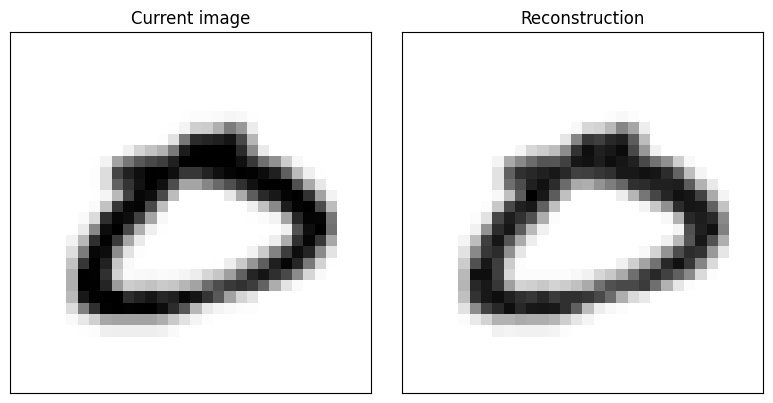

In [216]:
dim = image_shape[0]*image_shape[1]
inpt_axes, inpt_ims = plot_input(
            datapoint["image"].view(image_shape),
            datum.view(int(total_timesteps / dt), dim).sum(0).view(image_shape),
        )

In [114]:
start = time()

train_dataloader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True)

im_input, classes = next(iter(dataloader()))
sim_input = {"simulated_input": im_input}

network.run(inputs, time=total_)

    for iii, batch in enumerate(tqdm(train_dataloader)):
        if step > n_train:
            break
        inputs = {"simulated input": batch["encoded_image"].view(time,
                                                                batch_size
                                                                1, 28, 28)}
        if step % update_interval == 0 and step ~= 0:
            label_vector = torch.tensor(labels, device=device)
            
        all_activity_pred = all_activity(spikes=spike_record,
                                        assignments=assignments)
            
            
    

Progress: 0 / 1 (0.00024271011352539062)


# Version 2: Feedback dendrites have spatially limited spans, relatively sparse connections

# Version 3: Feedback dendrites have unlimited span and connect to all